In [1]:
import ast
from pprint import pprint

import networkx as nx
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from graph_reinforcement_learning_using_blockchain_data import config

config.load_dotenv()

2025-05-31 12:44:21.642 | INFO     | graph_reinforcement_learning_using_blockchain_data.config:<module>:12 - PROJ_ROOT path is: /Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data


True

In [2]:
df_class1 = pd.read_csv(config.RAW_DATA_DIR / "receipts_class1.csv")
print(len(df_class1))
df_class1 = df_class1[df_class1["logs"] != "[]"]
print(len(df_class1))

107435
106414


In [3]:
df_class0 = pd.read_csv(config.RAW_DATA_DIR / "receipts_class0.csv")
print(len(df_class0))
df_class0 = df_class0[df_class0["logs"] != "[]"]
print(len(df_class0))

114939
74649


In [4]:
df_class1.head()

,id,created_at,account_address,profit_token_address,block_number,transaction_hash,start_amount,end_amount,profit_amount,error,...,gasUsed,contractAddress,cumulativeGasUsed,transactionIndex,from,to,type,effectiveGasPrice,logs,status
0,7108fc71-883d-45b2-a6d4-0da61eb0a777,2023-05-18 15:32:43.208654,0x4870525eae23fceb31df613d179ef6275e1b93a9,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,16950601,0x7836e253e6b932564e23e3162badd365ff8fbfa93f9f...,54865003552880478,62515568704076031,7650565151195553,NaN,...,888515,NaN,6869698,84,0x76F36d497b51e48A288f03b4C1d7461e92247d5e,0x4870525EAE23FceB31DF613d179ef6275e1B93a9,2,18442443468,[{'blockHash': '0x196c250ac3f953b996f9024ec93c...,1
1,23cd0052-4fb9-4ded-a6ff-5c2c7998f24d,2023-05-18 15:32:45.587223,0x4870525eae23fceb31df613d179ef6275e1b93a9,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,16950602,0x299048408548ccd465e99a83d7342467a65a780064f4...,89185111706660168,92271485564350625,3086373857690457,NaN,...,134174,NaN,234517,1,0x76F36d497b51e48A288f03b4C1d7461e92247d5e,0x4870525EAE23FceB31DF613d179ef6275e1B93a9,2,22784177013,[{'blockHash': '0xb7b27a4871eba9cd96bf6b2704b2...,1
2,a37c326f-9630-4034-ba32-4dd24544a5f2,2023-05-18 15:32:53.751029,0x4870525eae23fceb31df613d179ef6275e1b93a9,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,16950607,0xb5ad6f9c677f1b7b618e9b138f601940f74a111b4004...,91060864908553544,96762829684099802,5701964775546258,NaN,...,265714,NaN,1712379,7,0x76F36d497b51e48A288f03b4C1d7461e92247d5e,0x4870525EAE23FceB31DF613d179ef6275e1B93a9,2,48743022382,[{'blockHash': '0x4d3c834264d0bd534ed21e72179f...,1
3,0fb64b84-3bf8-4ca2-a5da-58c89fda51e1,2023-05-18 15:32:53.751029,0x7efd91c8ca31e7452c5c4de00a8ca1c18910a35f,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,16950607,0xbd92de852e56dcb439aa576a0161fe5b8e0ab0735ef4...,554451451942816833,561352734048392148,6901282105575315,NaN,...,207066,NaN,2289525,10,0x28341B173178E37f0Cd2A5B35A09A60d70c6f12C,0x7EfD91c8CA31e7452C5c4DE00A8cA1c18910a35F,0,21565440686,[{'blockHash': '0x4d3c834264d0bd534ed21e72179f...,1
4,26170f74-d174-4fec-a07f-7f95b9eb90cb,2023-05-18 15:33:07.228647,0x4870525eae23fceb31df613d179ef6275e1b93a9,0xdac17f958d2ee523a2206206994597c13d831ec7,16950616,0x84def9f72e2962af2c27ed8a95a84971c00212dc23b7...,920317261,929402944,9085683,NaN,...,358505,NaN,2160707,8,0x76F36d497b51e48A288f03b4C1d7461e92247d5e,0x4870525EAE23FceB31DF613d179ef6275e1B93a9,2,31432937487,[{'blockHash': '0xb9a0877950fc5fad63d8f15463d0...,1


In [5]:
df_class0.head()

,block_number,transaction_hash,blockHash,blockNumber,logsBloom,gasUsed,contractAddress,cumulativeGasUsed,transactionIndex,from,to,type,effectiveGasPrice,logs,status
2,16950601,0x07d24a0c6b2837c5731ad659f62c59b935b2195e70dc...,0x196c250ac3f953b996f9024ec93c3cd073c5f31fc150...,16950601,0x00200000000000000000800080000000000800000000...,157316,NaN,2135061,12,0xf44329d7915C95Cad0510D8174accDFBceABc16d,0xEf1c6E67703c7BD7107eed8303Fbe6EC2554BF6B,2,50000000000,[{'blockHash': '0x196c250ac3f953b996f9024ec93c...,1
4,16950601,0x7e3b9d96c2c7b2e3fd4cf4fb8b8a97f004861d6087fc...,0x196c250ac3f953b996f9024ec93c3cd073c5f31fc150...,16950601,0x00000000000000000000000000000000000000000000...,48537,NaN,10131517,140,0x4E5B2e1dc63F6b91cb6Cd759936495434C7e972F,0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48,0,22000000000,[{'blockHash': '0x196c250ac3f953b996f9024ec93c...,1
7,16950601,0x829e063b46be14c2aee305bd47b9a8a0b39e45188f7b...,0x196c250ac3f953b996f9024ec93c3cd073c5f31fc150...,16950601,0x00000000000000000000000000000000000000000200...,62833,NaN,5225102,71,0x584cE70eCfECeea309675726875e8E0Fdbc08b20,0xa24787320ede4CC19D800bf87B41Ab9539c4dA9D,2,19360969611,[{'blockHash': '0x196c250ac3f953b996f9024ec93c...,1
12,16950601,0x3697d02c0d3b972fce90722bc42c91fe8a6d6d8137be...,0x196c250ac3f953b996f9024ec93c3cd073c5f31fc150...,16950601,0x00000800000000000000000000000020000000000000...,172470,NaN,3799719,44,0x301e2D2a98c5873AC27Fd9eae85F0153959100Fa,0x00000000000001ad428e4906aE43D8F9852d0dD6,0,20100000000,[{'blockHash': '0x196c250ac3f953b996f9024ec93c...,1
15,16950601,0xaf94feedf4330e4a5c2bf084d2e6739652287dbfc6e0...,0x196c250ac3f953b996f9024ec93c3cd073c5f31fc150...,16950601,0x00000000000000000000000000000000000000000000...,254032,NaN,2564577,16,0xC6c7565644EA1893ad29182F7B6961AAb7EDFeD0,0xA88800CD213dA5Ae406ce248380802BD53b47647,2,22568554601,[{'blockHash': '0x196c250ac3f953b996f9024ec93c...,1


## Features edges

In [6]:
# See notebook 2.01-signatures-arbitrages_with_logs.ipynb
top_class0_signatures = [
    "0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef",
    "0x8c5be1e5ebec7d5bd14f71427d1e84f3dd0314c0f7b2291e5b200ac8c7c3b925",
    "0x1c411e9a96e071241c2f21f7726b17ae89e3cab4c78be50e062b03a9fffbbad1",
    "0xd78ad95fa46c994b6551d0da85fc275fe613ce37657fb8d5e3d130840159d822",
    "0xe1fffcc4923d04b559f4d29a8bfc6cda04eb5b0d3c460751c2402c5c5cc9109c",
    "0x7fcf532c15f0a6db0bd6d0e038bea71d30d808c7d98cb3bf7268a95bf5081b65",
    "0xc42079f94a6350d7e6235f29174924f928cc2ac818eb64fed8004e115fbcca67",
    "0xe9149e1b5059238baed02fa659dbf4bd932fbcf760a431330df4d934bc942f37",
    "0x9d9af8e38d66c62e2c12f0225249fd9d721c54b83f48d9352c97c6cacdcb6f31",
    "0x17307eab39ab6107e8899845ad3d59bd9653f200f220920489ca2b5937696c31",
]

top_class1_signatures = [
    "0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef",
    "0x1c411e9a96e071241c2f21f7726b17ae89e3cab4c78be50e062b03a9fffbbad1",
    "0xd78ad95fa46c994b6551d0da85fc275fe613ce37657fb8d5e3d130840159d822",
    "0xc42079f94a6350d7e6235f29174924f928cc2ac818eb64fed8004e115fbcca67",
    "0x8c5be1e5ebec7d5bd14f71427d1e84f3dd0314c0f7b2291e5b200ac8c7c3b925",
    "0x7fcf532c15f0a6db0bd6d0e038bea71d30d808c7d98cb3bf7268a95bf5081b65",
    "0x19b47279256b2a23a1665c810c8d55a1758940ee09377d4f8d26497a3577dc83",
    "0x908fb5ee8f16c6bc9bc3690973819f32a4d4b10188134543c88706e0e1d43378",
    "0xddac40937f35385a34f721af292e5a83fc5b840f722bff57c2fc71adba708c48",
    "0x8201aa3f00000000000000000000000000000000000000000000000000000000",
]

top_signatures = list(set(top_class0_signatures + top_class1_signatures))

In [7]:
def extract_receipt_features(tx_receipt, top_signatures):
    features = {}
    features["transactionHash"] = tx_receipt["transaction_hash"]
    features["blockNumber"] = tx_receipt["blockNumber"]
    features["gasUsed"] = tx_receipt["gasUsed"]
    features["cumulativeGasUsed"] = tx_receipt["cumulativeGasUsed"]
    features["transactionIndex"] = tx_receipt["transactionIndex"]
    features["effectiveGasPrice"] = tx_receipt["effectiveGasPrice"]
    features["status"] = tx_receipt["status"]
    features["fee"] = features["gasUsed"] * features["effectiveGasPrice"]

    features["from"] = tx_receipt["from"]
    features["to"] = tx_receipt["to"]

    logs = tx_receipt["logs"]
    logs = ast.literal_eval(logs)

    features["num_logs"] = len(logs)
    event_counts = {}
    for log in logs:
        topics = log.get("topics", [])
        if topics:
            sig = topics[0].hex() if hasattr(topics[0], "hex") else str(topics[0])
            event_counts[sig] = event_counts.get(sig, 0) + 1

    for sig in top_signatures:
        features[f"dummy_{sig[:10]}"] = 1 if sig in event_counts else 0

    return pd.Series(features)

In [8]:
df_class1_features = df_class1.apply(
    extract_receipt_features, axis=1, top_signatures=top_signatures
)

In [9]:
df_class1_features.head()

,transactionHash,blockNumber,gasUsed,cumulativeGasUsed,transactionIndex,effectiveGasPrice,status,fee,from,to,...,dummy_0x9d9af8e3,dummy_0x908fb5ee,dummy_0x7fcf532c,dummy_0xd78ad95f,dummy_0x17307eab,dummy_0x8c5be1e5,dummy_0xddac4093,dummy_0xc42079f9,dummy_0x19b47279,dummy_0x8201aa3f
0,0x7836e253e6b932564e23e3162badd365ff8fbfa93f9f...,16950601,888515,6869698,84,18442443468,1,16386387657970020,0x76F36d497b51e48A288f03b4C1d7461e92247d5e,0x4870525EAE23FceB31DF613d179ef6275e1B93a9,...,0,0,0,1,0,0,0,1,0,0
1,0x299048408548ccd465e99a83d7342467a65a780064f4...,16950602,134174,234517,1,22784177013,1,3057044166542262,0x76F36d497b51e48A288f03b4C1d7461e92247d5e,0x4870525EAE23FceB31DF613d179ef6275e1B93a9,...,0,0,0,1,0,0,0,1,0,0
2,0xb5ad6f9c677f1b7b618e9b138f601940f74a111b4004...,16950607,265714,1712379,7,48743022382,1,12951703449210748,0x76F36d497b51e48A288f03b4C1d7461e92247d5e,0x4870525EAE23FceB31DF613d179ef6275e1B93a9,...,0,0,0,1,0,0,0,1,0,0
3,0xbd92de852e56dcb439aa576a0161fe5b8e0ab0735ef4...,16950607,207066,2289525,10,21565440686,1,4465469541087276,0x28341B173178E37f0Cd2A5B35A09A60d70c6f12C,0x7EfD91c8CA31e7452C5c4DE00A8cA1c18910a35F,...,0,0,0,1,0,0,0,1,0,0
4,0x84def9f72e2962af2c27ed8a95a84971c00212dc23b7...,16950616,358505,2160707,8,31432937487,1,11268865253776935,0x76F36d497b51e48A288f03b4C1d7461e92247d5e,0x4870525EAE23FceB31DF613d179ef6275e1B93a9,...,0,0,0,1,0,0,0,1,0,0


In [10]:
df_class0_features = df_class0.apply(
    extract_receipt_features, axis=1, top_signatures=top_signatures
)

In [11]:
df_class0_features.head()

,transactionHash,blockNumber,gasUsed,cumulativeGasUsed,transactionIndex,effectiveGasPrice,status,fee,from,to,...,dummy_0x9d9af8e3,dummy_0x908fb5ee,dummy_0x7fcf532c,dummy_0xd78ad95f,dummy_0x17307eab,dummy_0x8c5be1e5,dummy_0xddac4093,dummy_0xc42079f9,dummy_0x19b47279,dummy_0x8201aa3f
2,0x07d24a0c6b2837c5731ad659f62c59b935b2195e70dc...,16950601,157316,2135061,12,50000000000,1,7865800000000000,0xf44329d7915C95Cad0510D8174accDFBceABc16d,0xEf1c6E67703c7BD7107eed8303Fbe6EC2554BF6B,...,0,0,0,1,0,0,0,0,0,0
4,0x7e3b9d96c2c7b2e3fd4cf4fb8b8a97f004861d6087fc...,16950601,48537,10131517,140,22000000000,1,1067814000000000,0x4E5B2e1dc63F6b91cb6Cd759936495434C7e972F,0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48,...,0,0,0,0,0,0,0,0,0,0
7,0x829e063b46be14c2aee305bd47b9a8a0b39e45188f7b...,16950601,62833,5225102,71,19360969611,1,1216507803567963,0x584cE70eCfECeea309675726875e8E0Fdbc08b20,0xa24787320ede4CC19D800bf87B41Ab9539c4dA9D,...,0,0,0,0,0,0,0,0,0,0
12,0x3697d02c0d3b972fce90722bc42c91fe8a6d6d8137be...,16950601,172470,3799719,44,20100000000,1,3466647000000000,0x301e2D2a98c5873AC27Fd9eae85F0153959100Fa,0x00000000000001ad428e4906aE43D8F9852d0dD6,...,1,0,0,0,0,0,0,0,0,0
15,0xaf94feedf4330e4a5c2bf084d2e6739652287dbfc6e0...,16950601,254032,2564577,16,22568554601,1,5733135062401232,0xC6c7565644EA1893ad29182F7B6961AAb7EDFeD0,0xA88800CD213dA5Ae406ce248380802BD53b47647,...,0,0,0,0,0,1,0,1,0,0


In [12]:
df_class0_features["label"] = 0
df_class1_features["label"] = 1

In [13]:
df_features_edges = pd.concat([df_class0_features, df_class1_features])
print(len(df_features_edges))
df_features_edges = df_features_edges.drop_duplicates(subset="transactionHash")
print(len(df_features_edges))

181063
180152


In [14]:
df_features_edges.describe()

,blockNumber,gasUsed,cumulativeGasUsed,transactionIndex,effectiveGasPrice,status,fee,num_logs,dummy_0x1c411e9a,dummy_0xe1fffcc4,...,dummy_0x908fb5ee,dummy_0x7fcf532c,dummy_0xd78ad95f,dummy_0x17307eab,dummy_0x8c5be1e5,dummy_0xddac4093,dummy_0xc42079f9,dummy_0x19b47279,dummy_0x8201aa3f,label
count,1.801520e+05,1.801520e+05,1.801520e+05,180152.000000,1.801520e+05,180152.0,1.801520e+05,180152.000000,180152.000000,180152.000000,...,180152.000000,180152.000000,180152.000000,180152.000000,180152.000000,180152.000000,180152.000000,180152.000000,180152.000000,180152.000000
mean,1.716441e+07,1.851657e+05,5.015147e+06,47.752892,8.848056e+10,1.0,1.748608e+16,7.026628,0.599449,0.051096,...,0.019389,0.062880,0.599044,0.019162,0.103302,0.003175,0.464691,0.025528,0.015892,0.585633
std,1.709611e+05,2.798093e+05,5.629979e+06,61.039671,3.373601e+11,0.0,6.853118e+16,8.514811,0.490011,0.220194,...,0.137889,0.242748,0.490093,0.137093,0.304353,0.056259,0.498753,0.157724,0.125059,0.492614
min,1.695060e+07,2.211100e+04,2.863000e+04,0.000000,1.152221e+10,1.0,3.397166e+14,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.700662e+07,1.144810e+05,9.954970e+05,5.000000,2.420427e+10,1.0,2.860544e+15,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.713172e+07,1.537290e+05,2.604922e+06,17.000000,3.691219e+10,1.0,6.242626e+15,6.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.730420e+07,2.173475e+05,7.442354e+06,80.000000,7.048372e+10,1.0,1.381036e+16,9.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.751777e+07,2.402678e+07,2.999378e+07,831.000000,3.810702e+13,1.0,7.302631e+18,960.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
df_features_edges.head()

,transactionHash,blockNumber,gasUsed,cumulativeGasUsed,transactionIndex,effectiveGasPrice,status,fee,from,to,...,dummy_0x908fb5ee,dummy_0x7fcf532c,dummy_0xd78ad95f,dummy_0x17307eab,dummy_0x8c5be1e5,dummy_0xddac4093,dummy_0xc42079f9,dummy_0x19b47279,dummy_0x8201aa3f,label
2,0x07d24a0c6b2837c5731ad659f62c59b935b2195e70dc...,16950601,157316,2135061,12,50000000000,1,7865800000000000,0xf44329d7915C95Cad0510D8174accDFBceABc16d,0xEf1c6E67703c7BD7107eed8303Fbe6EC2554BF6B,...,0,0,1,0,0,0,0,0,0,0
4,0x7e3b9d96c2c7b2e3fd4cf4fb8b8a97f004861d6087fc...,16950601,48537,10131517,140,22000000000,1,1067814000000000,0x4E5B2e1dc63F6b91cb6Cd759936495434C7e972F,0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48,...,0,0,0,0,0,0,0,0,0,0
7,0x829e063b46be14c2aee305bd47b9a8a0b39e45188f7b...,16950601,62833,5225102,71,19360969611,1,1216507803567963,0x584cE70eCfECeea309675726875e8E0Fdbc08b20,0xa24787320ede4CC19D800bf87B41Ab9539c4dA9D,...,0,0,0,0,0,0,0,0,0,0
12,0x3697d02c0d3b972fce90722bc42c91fe8a6d6d8137be...,16950601,172470,3799719,44,20100000000,1,3466647000000000,0x301e2D2a98c5873AC27Fd9eae85F0153959100Fa,0x00000000000001ad428e4906aE43D8F9852d0dD6,...,0,0,0,0,0,0,0,0,0,0
15,0xaf94feedf4330e4a5c2bf084d2e6739652287dbfc6e0...,16950601,254032,2564577,16,22568554601,1,5733135062401232,0xC6c7565644EA1893ad29182F7B6961AAb7EDFeD0,0xA88800CD213dA5Ae406ce248380802BD53b47647,...,0,0,0,0,1,0,1,0,0,0


In [16]:
# nan values
df_features_edges.isna().sum()

transactionHash       0
blockNumber           0
gasUsed               0
cumulativeGasUsed     0
transactionIndex      0
effectiveGasPrice     0
status                0
fee                   0
from                  0
to                   77
num_logs              0
dummy_0x1c411e9a      0
dummy_0xe1fffcc4      0
dummy_0xddf252ad      0
dummy_0xe9149e1b      0
dummy_0x9d9af8e3      0
dummy_0x908fb5ee      0
dummy_0x7fcf532c      0
dummy_0xd78ad95f      0
dummy_0x17307eab      0
dummy_0x8c5be1e5      0
dummy_0xddac4093      0
dummy_0xc42079f9      0
dummy_0x19b47279      0
dummy_0x8201aa3f      0
label                 0
dtype: int64

In [17]:
df_features_edges.dropna(inplace=True)

In [18]:
len(df_features_edges)

180075

In [19]:
df_features_edges["blockNumber"].max() - df_features_edges["blockNumber"].min()

567172

In [20]:
def plot_hist(df, label_name):
    sns.set(style="whitegrid")

    plt.figure(figsize=(8, 6))
    ax = sns.histplot(df[label_name], bins=2, discrete=True)

    for p in ax.patches:
        ax.annotate(
            f"{int(p.get_height())}",
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="center",
            xytext=(0, 10),
            textcoords="offset points",
        )

    ax.set_xticks([0, 1])
    ax.set_xlabel("Class Label")
    ax.set_ylabel("Count")
    ax.set_title("Histogram of Class Labels")

    plt.show()

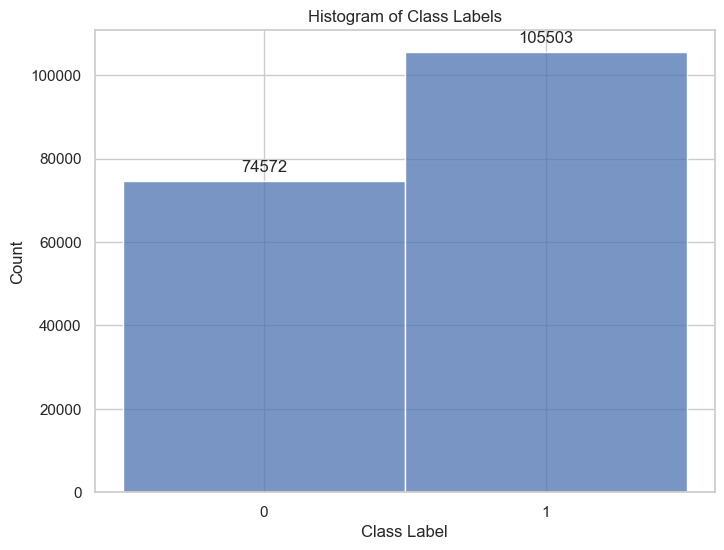

In [21]:
plot_hist(df_features_edges, "label")

In [22]:
# df_features_edges.to_csv(
#     config.PROCESSED_DATA_DIR / "flashbots" / "Q2_2023" / "features_edges_without_0logs.csv",
#     index=False,
# )

## Features nodes

In [23]:
dummy_cols = [col for col in df_features_edges.columns if col.startswith("dummy_")]

agg_dict = {
    "gasUsed": ["mean"],
    "cumulativeGasUsed": ["mean"],
    "transactionIndex": ["min", "max", "mean"],
    "effectiveGasPrice": ["mean", "max"],
    "status": "mean",  # proportion of successful transactions
    "fee": ["mean"],
    "label": "max",  # If any transaction is arbitrage (1), then account is arbitrage
    "num_logs": ["min", "max", "mean"],
}

for col in dummy_cols:
    agg_dict[col] = "mean"

df_accounts = df_features_edges.groupby("from").agg(agg_dict)

df_accounts.columns = [
    "_".join(col).strip() if isinstance(col, tuple) else col for col in df_accounts.columns.values
]

df_accounts = df_accounts.rename(
    columns={
        "label_max": "account_label",
    }
)

df_accounts = df_accounts.reset_index().rename(columns={"from": "account"})

In [24]:
df_accounts.head()

,account,gasUsed_mean,cumulativeGasUsed_mean,transactionIndex_min,transactionIndex_max,transactionIndex_mean,effectiveGasPrice_mean,effectiveGasPrice_max,status_mean,fee_mean,...,dummy_0x9d9af8e3_mean,dummy_0x908fb5ee_mean,dummy_0x7fcf532c_mean,dummy_0xd78ad95f_mean,dummy_0x17307eab_mean,dummy_0x8c5be1e5_mean,dummy_0xddac4093_mean,dummy_0xc42079f9_mean,dummy_0x19b47279_mean,dummy_0x8201aa3f_mean
0,0x00000000000124d994209fbB955E0217B5C2ECA1,153953.333333,2349512.5,3,39,18.833333,4.240266e+10,62912040686,1.0,6.261262e+15,...,0.0,0.0,0.5,0.500000,0.0,0.5,0.0,0.833333,0.000000,0.0
1,0x0000000000055772357E58581A2A2C5C6D9E8F64,184302.852632,2044586.4,0,94,12.789474,4.014352e+10,356581638821,1.0,7.352653e+15,...,0.0,0.0,0.0,0.515789,0.0,0.0,0.0,0.968421,0.515789,0.0
2,0x00000000000FFE26043F4C963A16612f8410A881,132305.000000,12121809.0,147,147,147.000000,2.896867e+10,28968672309,1.0,3.832700e+15,...,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.000000,0.000000,0.0
3,0x0000000000d14562212733C7DA3923DFe2613603,101080.000000,21705964.0,232,232,232.000000,2.640542e+10,26405422524,1.0,2.669060e+15,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
4,0x0000000007cB415122b0049a88bf24841260050e,46563.000000,16124385.0,166,166,166.000000,1.782762e+10,17827622923,1.0,8.301076e+14,...,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.000000,0.000000,0.0


In [25]:
len(df_accounts)

55043

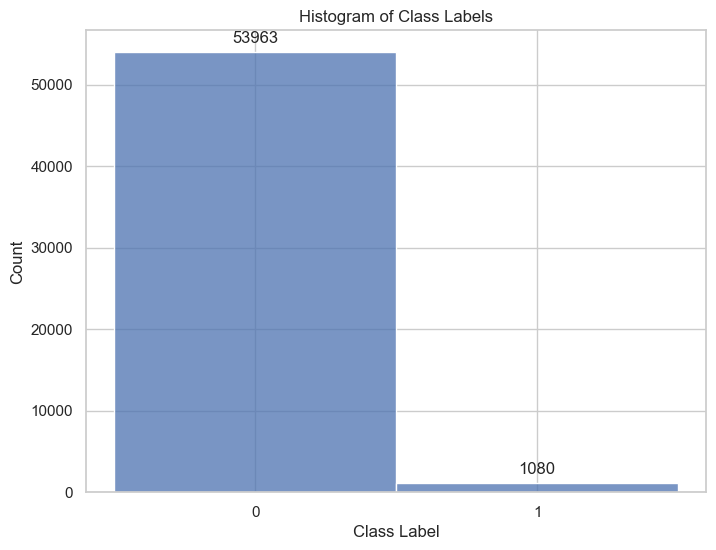

In [26]:
plot_hist(df_accounts, "account_label")

In [27]:
# df_accounts.to_csv(
#     config.PROCESSED_DATA_DIR / "flashbots" / "Q2_2023" / "features_nodes_improved.csv",
#     index=False,
# )

## Graph Features over all transactions

In [28]:
def add_graph_features(df):
    df_block = df.copy()

    G = nx.from_pandas_edgelist(df_block, source="from", target="to", create_using=nx.DiGraph())
    in_degrees = dict(G.in_degree())
    out_degrees = dict(G.out_degree())

    G_undirected = G.to_undirected()
    clustering = nx.clustering(G_undirected)

    def common_neighbors_count(u, v):
        return len(list(nx.common_neighbors(G_undirected, u, v)))

    df_block["from_in_degree"] = df_block["from"].apply(lambda x: in_degrees.get(x, 0))
    df_block["from_out_degree"] = df_block["from"].apply(lambda x: out_degrees.get(x, 0))
    df_block["to_in_degree"] = df_block["to"].apply(lambda x: in_degrees.get(x, 0))
    df_block["to_out_degree"] = df_block["to"].apply(lambda x: out_degrees.get(x, 0))
    df_block["common_neighbors"] = df_block.apply(
        lambda row: common_neighbors_count(row["from"], row["to"]), axis=1
    )
    df_block["from_clustering"] = df_block["from"].apply(lambda x: clustering.get(x, 0))
    df_block["to_clustering"] = df_block["to"].apply(lambda x: clustering.get(x, 0))

    return df_block

In [35]:
df_features_edges_graph = add_graph_features(df_features_edges)
print(len(df_features_edges_graph))

180075


In [44]:
df_features_edges_graph.head()

,transactionHash,blockNumber,gasUsed,cumulativeGasUsed,transactionIndex,effectiveGasPrice,status,fee,from,to,...,dummy_0x19b47279,dummy_0x8201aa3f,label,from_in_degree,from_out_degree,to_in_degree,to_out_degree,common_neighbors,from_clustering,to_clustering
2,0x07d24a0c6b2837c5731ad659f62c59b935b2195e70dc...,16950601,157316,2135061,12,50000000000,1,7865800000000000,0xf44329d7915C95Cad0510D8174accDFBceABc16d,0xEf1c6E67703c7BD7107eed8303Fbe6EC2554BF6B,...,0,0,0,0,1,5768,0,0,0,0
4,0x7e3b9d96c2c7b2e3fd4cf4fb8b8a97f004861d6087fc...,16950601,48537,10131517,140,22000000000,1,1067814000000000,0x4E5B2e1dc63F6b91cb6Cd759936495434C7e972F,0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48,...,0,0,0,0,4,1976,0,0,0,0
7,0x829e063b46be14c2aee305bd47b9a8a0b39e45188f7b...,16950601,62833,5225102,71,19360969611,1,1216507803567963,0x584cE70eCfECeea309675726875e8E0Fdbc08b20,0xa24787320ede4CC19D800bf87B41Ab9539c4dA9D,...,0,0,0,0,1,40,0,0,0,0
12,0x3697d02c0d3b972fce90722bc42c91fe8a6d6d8137be...,16950601,172470,3799719,44,20100000000,1,3466647000000000,0x301e2D2a98c5873AC27Fd9eae85F0153959100Fa,0x00000000000001ad428e4906aE43D8F9852d0dD6,...,0,0,0,0,1,2314,0,0,0,0
15,0xaf94feedf4330e4a5c2bf084d2e6739652287dbfc6e0...,16950601,254032,2564577,16,22568554601,1,5733135062401232,0xC6c7565644EA1893ad29182F7B6961AAb7EDFeD0,0xA88800CD213dA5Ae406ce248380802BD53b47647,...,0,0,0,0,1,5,0,0,0,0


In [36]:
# df_features_edges_graph.to_csv(
#     config.PROCESSED_DATA_DIR / "flashbots" / "Q2_2023" / "features_edges_graph.csv", index=False
# )

## Graph Features per block

In [37]:
df_edge_features_by_block = (
    df_features_edges.groupby("blockNumber").apply(add_graph_features).reset_index(drop=True)
)

/var/folders/zd/5rj11nhj5h98j5kmp_lp5k5w0000gn/T/ipykernel_35647/588891841.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_features_edges.groupby("blockNumber").apply(add_graph_features).reset_index(drop=True)


In [43]:
df_edge_features_by_block.tail()

,transactionHash,blockNumber,gasUsed,cumulativeGasUsed,transactionIndex,effectiveGasPrice,status,fee,from,to,...,dummy_0x19b47279,dummy_0x8201aa3f,label,from_in_degree,from_out_degree,to_in_degree,to_out_degree,common_neighbors,from_clustering,to_clustering
180070,0xe9e4267a40f834c34c639d98db0d58ec16de6987d3ed...,17517746,390555,1761709,5,68040034164,1,26573375542921020,0x758E8229Dd38cF11fA9E7c0D5f790b4CA16b3B16,0x000000000005aF2DDC1a93A03e9b7014064d3b8D,...,0,0,1,0,1,1,0,0,0,0
180071,0x4dd894e85ca011b493c4c135cb44ef2db5f22b8a76f4...,17517746,454597,454597,0,13151775097,1,5978757503770909,0x758E8229Dd38cF11fA9E7c0D5f790b4CA16b3B16,0x000000000005aF2DDC1a93A03e9b7014064d3b8D,...,0,0,1,0,1,1,0,0,0,0
180072,0x6f800b845f1f974690d9d1f3919bfc83e776c6be3ce0...,17517762,366395,827786,1,71363849347,1,26147357581494065,0x76F36d497b51e48A288f03b4C1d7461e92247d5e,0x2d2A7d56773ae7d5c7b9f1B57f7Be05039447B4D,...,0,0,1,0,1,1,0,0,0,0
180073,0x05b277e32ff184d649a8da4d2591f85db8ea7e87aec6...,17517766,206667,10314254,127,13140053022,1,2715615337897674,0x00000006e42915A2B6907f8b3fAF311B68862f60,0xA80Db00007020E013fA10D0560700C0018003B8b,...,0,0,1,0,1,1,0,0,0,0
180074,0x22ebd8578a408441394bf8c5d995d6ea8fd69fd809d6...,17517773,254102,475553,1,13372249592,1,3397915365826384,0xae2Fc483527B8EF99EB5D9B44875F005ba1FaE13,0x6b75d8AF000000e20B7a7DDf000Ba900b4009A80,...,0,0,1,0,1,1,0,0,0,0


In [39]:
df_edge_features_by_block.to_csv(
    config.PROCESSED_DATA_DIR / "flashbots" / "Q2_2023" / "features_edges_graph_by_block.csv",
    index=False,
)

## Graph Metrics

In [40]:
def compute_graph_metrics(G):
    simple_G = nx.DiGraph(G)

    density = nx.density(simple_G)

    avg_degree = (
        sum(dict(simple_G.degree()).values()) / simple_G.number_of_nodes()
        if simple_G.number_of_nodes() > 0
        else 0
    )

    clustering_coeff = nx.average_clustering(simple_G.to_undirected())

    components = list(nx.weakly_connected_components(simple_G))
    largest_component_size = max((len(c) for c in components), default=0)
    num_isolated_nodes = len(list(nx.isolates(simple_G)))

    degree_distribution = {}
    for node, degree in simple_G.degree():
        degree_distribution[degree] = degree_distribution.get(degree, 0) + 1

    return {
        "size": simple_G.number_of_nodes(),
        "density": density,
        "average_degree": avg_degree,
        "clustering_coefficient": clustering_coeff,
        "largest_component_size": largest_component_size,
        "num_isolated_nodes": num_isolated_nodes,
        "degree_distribution": degree_distribution,
    }

In [41]:
metrics = compute_graph_metrics(G)

NameError: name 'G' is not defined

In [101]:
pprint(metrics)

{'average_degree': 1.7626387725644634,
 'clustering_coefficient': 0.0008382579089858824,
 'degree_distribution': {1: 102060,
                         2: 6378,
                         3: 1453,
                         4: 651,
                         5: 310,
                         6: 212,
                         7: 155,
                         8: 105,
                         9: 85,
                         10: 74,
                         11: 55,
                         12: 45,
                         13: 43,
                         14: 42,
                         15: 28,
                         16: 32,
                         17: 33,
                         18: 22,
                         19: 21,
                         20: 16,
                         21: 21,
                         22: 17,
                         23: 10,
                         24: 9,
                         25: 9,
                         26: 12,
                         27: 10,
                  

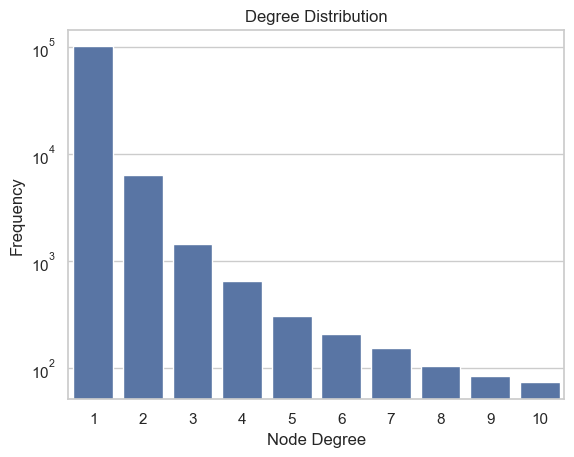

In [102]:
top_degrees = sorted(metrics["degree_distribution"].items(), key=lambda x: x[1], reverse=True)[:10]
sns.barplot(x=[d[0] for d in top_degrees], y=[d[1] for d in top_degrees])
plt.yscale("log")
plt.xlabel("Node Degree")
plt.ylabel("Frequency")
plt.title("Degree Distribution")
plt.show()